In [2]:
%matplotlib inline
from os import listdir
from os.path import isfile, join
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
import statsmodels.stats.multitest as smt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.colors import DivergingNorm
from collections import Counter

## 1. GO Enrichment McDonald-Kreitman test. ClusterProfiler

In [132]:
def load_all_GOresults(dbs, input_file, dos):
    
    DF_dbs = {}
    for db in dbs:
        file_name = input_file.format(db, dos)
        file_data = glob(file_name)[0]
        df = pd.read_csv(file_data, sep='\t')

        if df.shape[0] > 0:
            df['GOfull'] = df['Description'] + '  ' + df['ID']
            df['logpval'] = - np.log10(df['pvalue'])
            df['ngenes'], df['nset'] = df['GeneRatio'].str.split('/').str
            df['ratio'] = (pd.to_numeric(df['ngenes']) / pd.to_numeric(df['nset']) * 1000).astype(int)
            DF_dbs[db] = df
    return DF_dbs

In [206]:
def plot_scatter_enrich(DF, out_pdf):
    
    nonzero_dbs = DF.keys()
    db_ratios = [DF[db].shape[0] for db in nonzero_dbs]
    height = sum([i.shape[0] for i in list(DF.values())])
    xlim = max([max(i['logpval']) for i in list(DF.values())]) + 1
    
    fig, axes = plt.subplots(len(nonzero_dbs), 1, gridspec_kw={'height_ratios': db_ratios}, 
                             figsize=(4, height))

    blue = '#2b83ba'
    red = '#d7191c'
    if dos == 'pos':
        c = red
    elif dos == 'neg':
        c = blue
    else:
        c = 'purple'

    i = 0
    for db in nonzero_dbs:
        axi = axes[i]
        dfi = DF_dbs[db]
#         sns.scatterplot(ax=axi, data=dfi, x='logpval', y='Description', size='ratio',
#                         sizes=(min(dfi['ratio']), max(dfi['ratio'])), color=c, alpha=0.7, linewidth=0)

        if len(dfi) == 1:
            axi.scatter(dfi['logpval'], [dfi['Description'].iloc[0]], s=dfi['ratio']*10, color=c, alpha=0.7)
        else:
            sns.scatterplot(ax=axi, data=dfi, x='logpval', y='Description', size='ratio',
                            sizes=(min(dfi['ratio']), max(dfi['ratio'])), color=c, alpha=0.7, linewidth=0)

        axi.set(xlim=(1.5, xlim), ylabel='')
        axi.set_title(db)
        axi.legend([], [], frameon=False)

        categories = dfi['Description'].unique()
        if db == 'indInd':
            print(categories)
        axi.set_yticks(range(len(categories)))
        axi.set_yticklabels(categories)

        i += 1

#     sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
#     fig.subplots_adjust(bottom=0, top=0.6, wspace=0, hspace=0.6)   
    fig.tight_layout()

    pdf_name = out_pdf
#     fig.savefig(pdf_name, bbox_inches='tight')

### 1.1. Load GO enrich MKT results

In [204]:
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'
dbs = ['vidMac', 'vidCha', 'anoImb', 'poeAcu', 'indInd', 'picPub', 'molAte', 'agePho']

## DoS > 0 or < 0?
# dos = 'pos'
dos = 'neg'

input_file = 'MK_test_{}_ncbi/impMKT/noChildren.{}.enrichGO.all_genes_BG.tsv'
DF_dbs = load_all_GOresults(dbs, dir_path+input_file, dos)

/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  if sys.path[0] == '':


### 1.2. Plot scatterplots GO term ~ f (p-value, count)

['cell-cell adhesion via plasma-membrane adhesion molecules']


/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


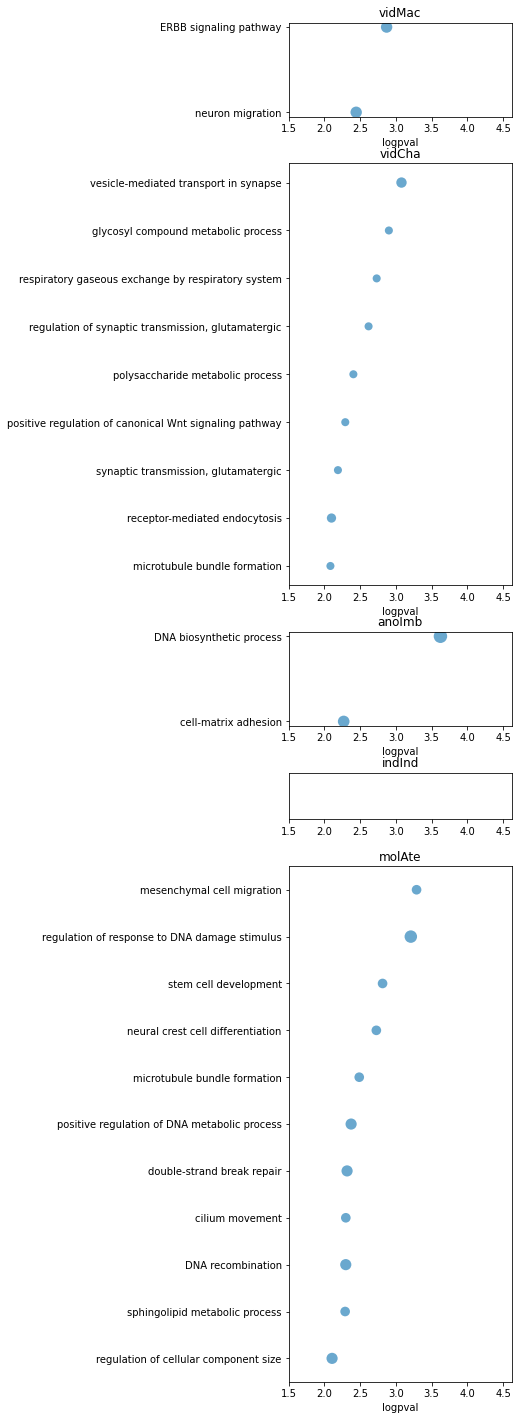

In [207]:
out_pdf = 'impMKT.{}.enrichGO.all_genes_BG.pval_0.01.clusterProfiler.pdf'.format(dos, len(dbs))

plot_scatter_enrich(DF_dbs, out_pdf)

## 2. Convergence analysis MKT results

### 2.0. Load functions necessary for convergence analysis

In [12]:
def count_gos(dbs, DF):
    all_goids = []
    for db in dbs:
        all_goids.extend(DF[db][DF[db]['pvalue'] < 0.05]['ID'])
    return Counter(all_goids)

In [20]:
def make_convergence_table(dbs, DF, target_go):
    data_target = {}
    for db in dbs:
        df_clade = DF[db]
        filt_df_clade = df_clade[(df_clade['ID'].isin(target_go))][['ID', 'Description', 'pvalue']]
        data_target[db] = filt_df_clade

    merged_df = pd.DataFrame({'ID': [], 'Description': []})
    for db in data_target:
        df = data_target[db]
        df['logP_{}'.format(db)] = np.log10(df['pvalue'])
        df.drop('pvalue', axis=1, inplace=True)
        merged_df = pd.merge(merged_df, df, on=['ID', 'Description'], how='outer')
        merged_df.set_index('Description', inplace=True)
        
    return merged_df

In [72]:
def plot_convergence_heatmap(df, out_pdf, vmin):

    ## Sort by p-values in a specified column
    df.sort_values(by=df.columns[1], inplace=True)

    ## Define purple color palette
    cmap_pval = sns.diverging_palette(285, 200, 100, as_cmap=True)
    divnorm_pval = DivergingNorm(vmin=vmin, vmax=0, vcenter=np.log10(0.051))
    
    pval_cols = [i for i in df.columns if i.startswith('logP_')]
    df_pval = df[pval_cols]

    fig, axes = plt.subplots(figsize=(4, len(df) / 2))
    sns.heatmap(data=df_pval, cmap=cmap_pval, norm=divnorm_pval)
    axes.set_ylabel('')
    fig.tight_layout()

    pdf_name = out_pdf
    plt.savefig(pdf_name, format='pdf', bbox_inches="tight")

### 2.1. Count in how many groups each GO is present

In [57]:
target_go_count = count_gos(dbs, DF_dbs)
rank2_target_go = [k for k in target_go_count if target_go_count[k] >= 2]
rank3_target_go = [k for k in target_go_count if target_go_count[k] >= 3]
print(len(rank2_target_go))
print(len(rank3_target_go))

10
0


### 2.2. For rank2 GO terms make a table of p-values from each db

In [58]:
rank2_df = make_convergence_table(dbs, DF_dbs, rank2_target_go)

rank2_df.to_csv('MKT.go_convergent_2clades.tsv', sep='\t')

### 2.3. Plot rank2 GO terms as a heatmap

/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  app.launch_new_instance()


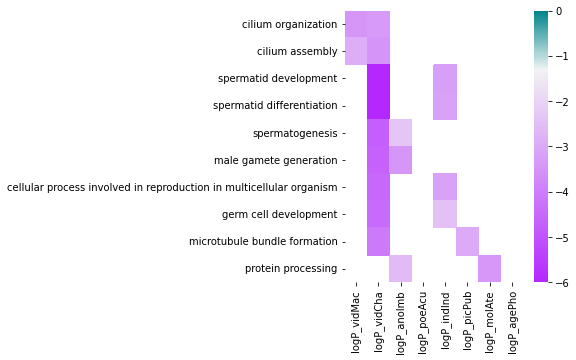

In [73]:
out_pdf = 'convergent_GOs.clusterProfiler.MKT.all_dbs.pdf'
vmin = -6
plot_convergence_heatmap(rank2_df, out_pdf, vmin)

## 3. SweepFinder2 GO enrichment analysis

### 3.1. Load SweepFinder2 GO enrichment results

In [98]:
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'
dbs = ['vidMac', 'vidCha', 'anoImb', 'poeAcu', 'indInd', 'picPub', 'molAte', 'agePho']

dos = ''

input_file = 'PopGen_{}/SF2.go_enrich.1Mb_domain.tsv'
DF_dbs = load_all_GOresults(dbs, dir_path+input_file, dos)

/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  del sys.path[0]


### 3.2. Plot scatterplots GO term ~ f (p-value, count)

/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


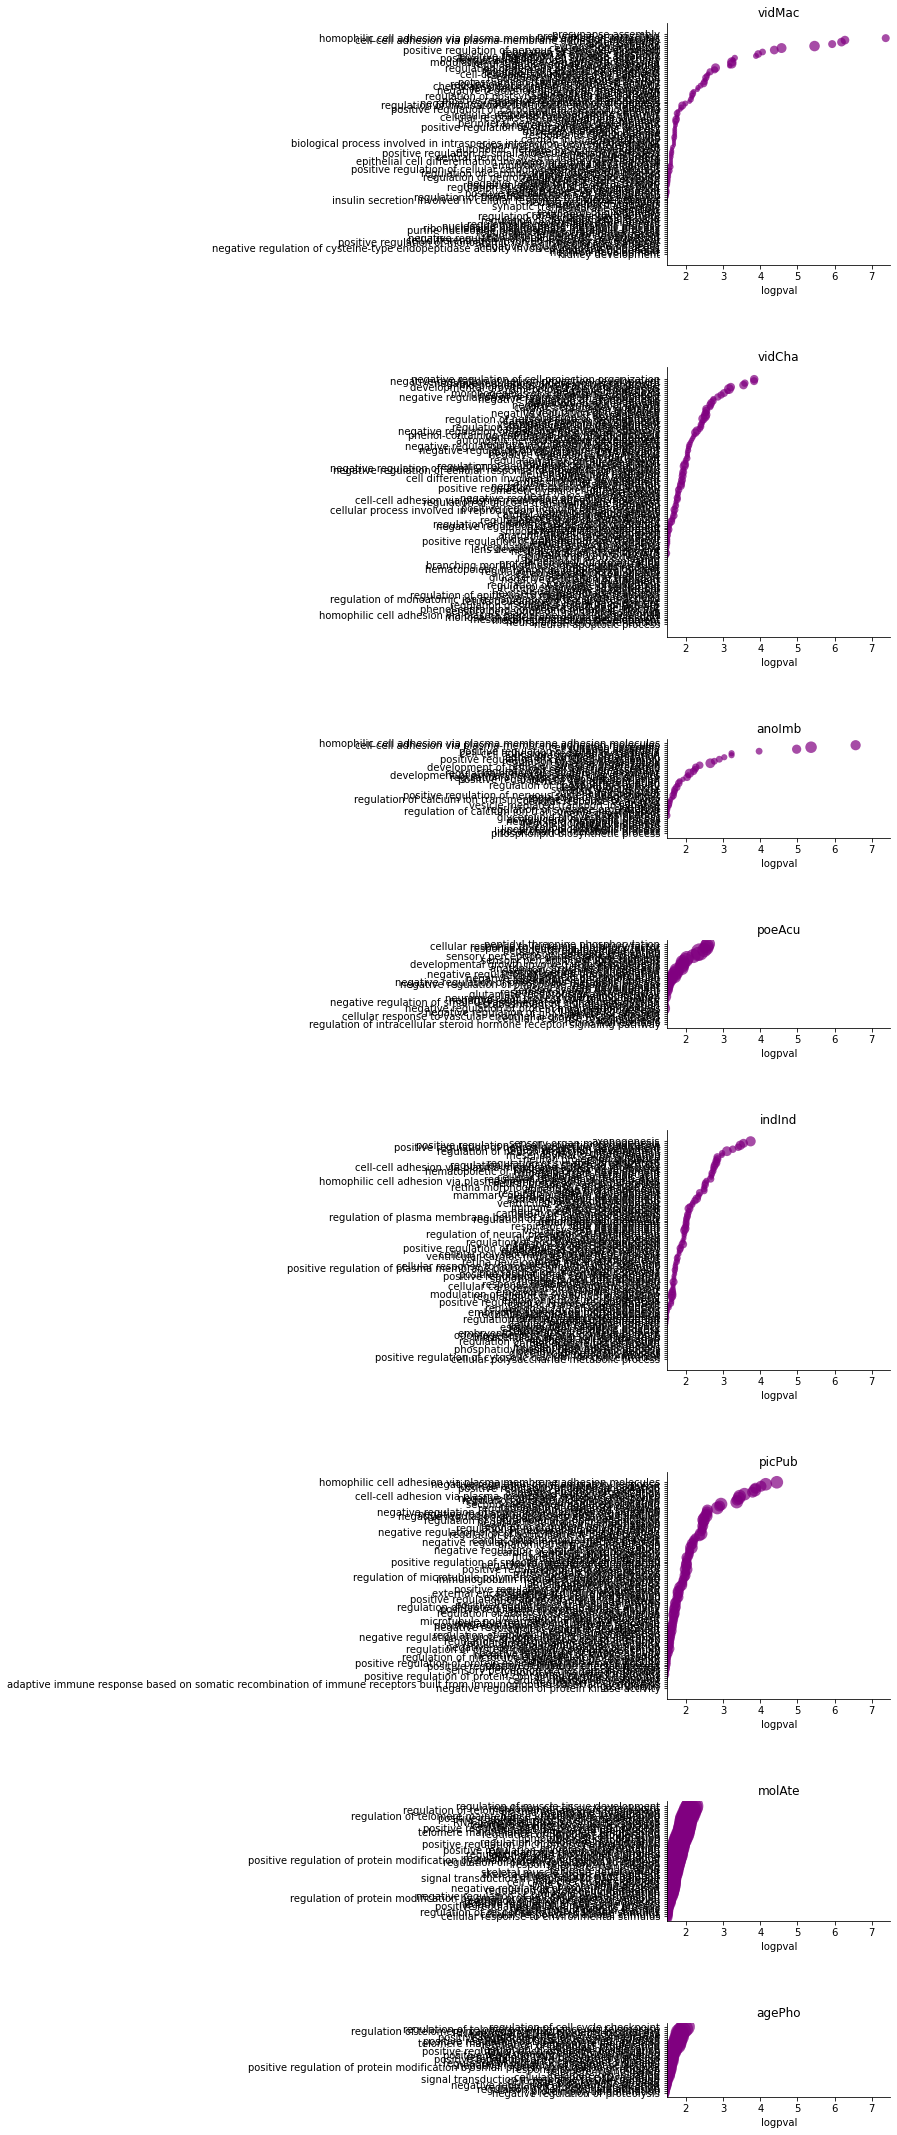

In [99]:
out_pdf = 'SF2_plots/clusterProfiler.sweepFinder2.goenrich.{}_dbs.pdf'.format(len(dbs))
plot_scatter_enrich(DF_dbs, out_pdf)

## 4. Convergence analysis SweepFinder2 results

### 4.1. Count in how many groups each GO is present

In [101]:
target_go_count = count_gos(dbs, DF_dbs)
rank2_target_go = [k for k in target_go_count if target_go_count[k] >= 2]
rank3_target_go = [k for k in target_go_count if target_go_count[k] >= 3]
print(len(rank2_target_go))
print(len(rank3_target_go))

110
22


### 4.2. For rank3 GO terms make a table of p-values from each db

In [103]:
rank3_df = make_convergence_table(dbs, DF_dbs, rank3_target_go)

# rank3_df.to_csv('SF2.go_convergent_3clades.tsv', sep='\t')

### 4.3. Remove children GO terms (see README for details)

In [107]:
to_exclude_children = ['GO:0099172', 'GO:0007156', 'GO:0007416', 'GO:0051962', 'GO:0051965', 
                       'GO:0034332', 'GO:0050807', 'GO:0043010', 'GO:0003231', 'GO:0001654', 'GO:0150063']
to_exclude = to_exclude_children

rank3_df = rank3_df[~rank3_df['ID'].isin(to_exclude)]

### 4.4. Plot rank3 GO terms as a heatmap

/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  app.launch_new_instance()


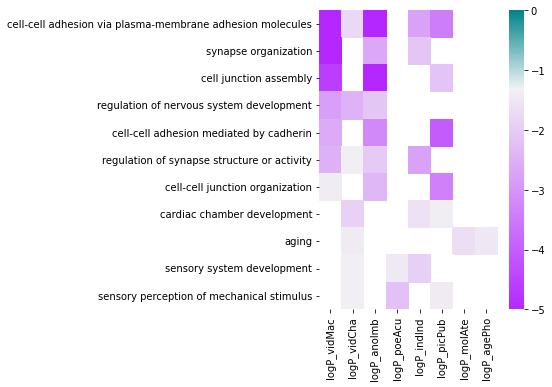

In [109]:
out_pdf = 'convergent_GOs.clusterProfiler.SF2.all_dbs.pdf'
vmin = -5
plot_convergence_heatmap(rank3_df, out_pdf, vmin)